In [1]:
import os
import random
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import json
from pathlib import Path

OUTPUT_PATH = 'font_dataset'
FONTS_PATH = 'fonts'

# Ensure the dataset directory exists
Path(OUTPUT_PATH).mkdir(parents=True, exist_ok=True)

def load_fonts(fonts_path):
    fonts = []
    for font_file in os.listdir(fonts_path):
        if font_file.lower().endswith(('.ttf', '.otf')):
            font_path = os.path.join(fonts_path, font_file)
            fonts.append(font_path)
    return fonts

def generate_line(text, font_path, font_size=32, line_height=64):
    font = ImageFont.truetype(font_path, font_size)
    line_image = Image.new('L', (1, line_height), color=255)
    draw = ImageDraw.Draw(line_image)
    text_width = draw.textlength(text, font=font)
    line_image = Image.new('L', (int(text_width), line_height), color=255)
    draw = ImageDraw.Draw(line_image)
    draw.text((0, (line_height - font_size) // 2), text, font=font, fill=0)
    return line_image

def generate_multiline_image(text, fonts, max_width=512, line_spacing=10, canvas_size=512):
    words = text.split()
    lines = []
    current_line = []
    
    adjusted_max_width = max_width + random.randint(-50, 50)
    
    for word in words:
        test_line = current_line + [word]
        test_image = generate_line(' '.join(test_line), random.choice(fonts))
        
        if test_image.width <= adjusted_max_width:
            current_line.append(word)
        else:
            if current_line:
                lines.append(' '.join(current_line))
            current_line = [word]
    
    if current_line:
        lines.append(' '.join(current_line))

    line_images = [generate_line(line, random.choice(fonts)) for line in lines]
    max_line_width = max(img.width for img in line_images)
    total_height = sum(img.height for img in line_images) + line_spacing * (len(line_images) - 1)
    target_width = min(max(max_line_width, canvas_size), adjusted_max_width)
    
    multiline_image = Image.new('L', (target_width, total_height), color=255)
    y_offset = 0
    
    for line_img in line_images:
        multiline_image.paste(line_img, ((target_width - line_img.width) // 2, y_offset))
        y_offset += line_img.height + line_spacing
    
    scale_factor = random.uniform(0.7, 0.9)
    resized_image = multiline_image.resize(
        (int(multiline_image.width * scale_factor), int(multiline_image.height * scale_factor)), Image.LANCZOS
    )
    
    text_representation = '\n'.join(lines)
    
    return resized_image, text_representation

def apply_color_map(image, cmap_name):
    cmap = plt.get_cmap(cmap_name)
    normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image))
    colored_image = cmap(normalized_image)
    colored_image = np.uint8(colored_image[:, :, :3] * 255)
    
    return Image.fromarray(colored_image)

def ensure_final_size(image, target_size=512):
    return image.resize((target_size, target_size), Image.LANCZOS)

def clean_text(text):
    return text.replace('.', '').replace('-', '')

# Load fonts
fonts = load_fonts(FONTS_PATH)

# Load prescriptions from prescriptions_flat.json
prescriptions_path = 'prescriptions_flat.json'

with open(prescriptions_path, 'r') as f:
    prescriptions = json.load(f)

# Synthetic data generation parameters
num_splits = 6
cmaps = ['gray', 'viridis', 'plasma', 'inferno', 'magma', 'cividis']
canvas_size = 512

image_data = []

for idx, prescription in enumerate(prescriptions):
    text = clean_text(prescription)
    
    for split_idx in range(num_splits):
        image, text_representation = generate_multiline_image(text, fonts, canvas_size=canvas_size)
        
        for cmap in cmaps:
            for rotation_idx in range(4):
                rotated_image = image.rotate(random.uniform(-15, 15), resample=Image.BILINEAR, expand=True)
                colored_image = apply_color_map(rotated_image, cmap)
                final_image = ensure_final_size(colored_image)
                
                image_filename = f"font_image_{idx+1}_split{split_idx+1}_{cmap}_rot{rotation_idx}.png"
                image_path = os.path.join(OUTPUT_PATH, image_filename).replace('\\', '/')
                final_image.save(image_path)
                
                data_entry = {
                    "query": "<image>what does this say?",
                    "response": text_representation,
                    "images": [image_path]
                }
                image_data.append(data_entry)

    print(f"Completed processing prescription {idx + 1}/{len(prescriptions)}")

# Save dataset to JSON file in the root directory
json_path = 'font_dataset.json'
with open(json_path, 'w') as f:
    json.dump(image_data, f, indent=4)

print(f"{num_splits * len(cmaps) * 4 * len(prescriptions)} synthetic images with different fonts, colormaps, and rotations have been generated and saved in {OUTPUT_PATH}.")

Completed processing prescription 1/52
Completed processing prescription 2/52
Completed processing prescription 3/52
Completed processing prescription 4/52
Completed processing prescription 5/52
Completed processing prescription 6/52
Completed processing prescription 7/52
Completed processing prescription 8/52
Completed processing prescription 9/52
Completed processing prescription 10/52
Completed processing prescription 11/52
Completed processing prescription 12/52
Completed processing prescription 13/52
Completed processing prescription 14/52
Completed processing prescription 15/52
Completed processing prescription 16/52
Completed processing prescription 17/52
Completed processing prescription 18/52
Completed processing prescription 19/52
Completed processing prescription 20/52
Completed processing prescription 21/52
Completed processing prescription 22/52
Completed processing prescription 23/52
Completed processing prescription 24/52
Completed processing prescription 25/52
Completed

In [6]:
import os
import random
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import json
from pathlib import Path

OUTPUT_PATH = 'font_dataset_2'
FONTS_PATH = 'fonts'

# Ensure the dataset directory exists
Path(OUTPUT_PATH).mkdir(parents=True, exist_ok=True)

def load_fonts(fonts_path):
    fonts = []
    for font_file in os.listdir(fonts_path):
        if font_file.lower().endswith(('.ttf', '.otf')):
            font_path = os.path.join(fonts_path, font_file)
            fonts.append(font_path)
    return fonts

def generate_line(text, font_path, font_size=48, line_height=96):  # Increased font size and line height
    font = ImageFont.truetype(font_path, font_size)
    line_image = Image.new('L', (1, line_height), color=255)
    draw = ImageDraw.Draw(line_image)
    text_width = draw.textlength(text, font=font)
    line_image = Image.new('L', (int(text_width), line_height), color=255)
    draw = ImageDraw.Draw(line_image)
    draw.text((0, (line_height - font_size) // 2), text, font=font, fill=0)
    return line_image

def generate_multiline_image(text, fonts, max_width=512, line_spacing=15, canvas_size=512):  # Increased line spacing
    words = text.split()
    lines = []
    current_line = []
    
    adjusted_max_width = max_width + random.randint(-50, 50)
    
    for word in words:
        test_line = current_line + [word]
        test_image = generate_line(' '.join(test_line), random.choice(fonts))
        
        if test_image.width <= adjusted_max_width:
            current_line.append(word)
        else:
            if current_line:
                lines.append(' '.join(current_line))
            current_line = [word]
    
    if current_line:
        lines.append(' '.join(current_line))

    line_images = [generate_line(line, random.choice(fonts)) for line in lines]
    max_line_width = max(img.width for img in line_images)
    total_height = sum(img.height for img in line_images) + line_spacing * (len(line_images) - 1)
    target_width = min(max(max_line_width, canvas_size), adjusted_max_width)
    
    multiline_image = Image.new('L', (target_width, total_height), color=255)
    y_offset = 0
    
    for line_img in line_images:
        multiline_image.paste(line_img, ((target_width - line_img.width) // 2, y_offset))
        y_offset += line_img.height + line_spacing
    
    scale_factor = random.uniform(0.8, 1.0)  # Adjusted scale factor for larger fonts
    resized_image = multiline_image.resize(
        (int(multiline_image.width * scale_factor), int(multiline_image.height * scale_factor)), Image.LANCZOS
    )
    
    text_representation = '\n'.join(lines)
    
    return resized_image, text_representation

def apply_color_map(image, cmap_name):
    cmap = plt.get_cmap(cmap_name)
    normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image))
    colored_image = cmap(normalized_image)
    colored_image = np.uint8(colored_image[:, :, :3] * 255)
    
    return Image.fromarray(colored_image)

def ensure_final_size(image, target_size=512):
    return image.resize((target_size, target_size), Image.LANCZOS)

def clean_text(text):
    return text.replace('.', '').replace('-', '')

# Load fonts
fonts = load_fonts(FONTS_PATH)

# Load prescriptions from prescriptions_flat.json
prescriptions_path = 'prescriptions_flat.json'

with open(prescriptions_path, 'r') as f:
    prescriptions = json.load(f)

# Synthetic data generation parameters
num_splits = 6
cmaps = ['gray', 'viridis', 'plasma', 'inferno', 'magma', 'cividis']
canvas_size = 512

image_data = []

for idx, prescription in enumerate(prescriptions):
    text = clean_text(prescription)
    
    for split_idx in range(num_splits):
        # Choose a different font for each split
        split_font = random.choice(fonts)
        image, text_representation = generate_multiline_image(text, [split_font], canvas_size=canvas_size)
        
        for cmap in cmaps:
            for rotation_idx in range(4):
                # Choose a different font for each rotation
                rotation_font = random.choice(fonts)
                rotated_image, _ = generate_multiline_image(text, [rotation_font], canvas_size=canvas_size)
                rotated_image = rotated_image.rotate(random.uniform(-15, 15), resample=Image.BILINEAR, expand=True)
                colored_image = apply_color_map(rotated_image, cmap)
                final_image = ensure_final_size(colored_image)
                
                image_filename = f"font_image_{idx+1}_split{split_idx+1}_{cmap}_rot{rotation_idx}.png"
                image_path = os.path.join(OUTPUT_PATH, image_filename).replace('\\', '/')
                final_image.save(image_path)
                
                data_entry = {
                    "query": "<image>what does this say?",
                    "response": text_representation,
                    "images": [image_path]
                }
                image_data.append(data_entry)

    print(f"Completed processing prescription {idx + 1}/{len(prescriptions)}")

# Save dataset to JSON file in the root directory
json_path = 'font_dataset.json'
with open(json_path, 'w') as f:
    json.dump(image_data, f, indent=4)

print(f"{num_splits * len(cmaps) * 4 * len(prescriptions)} synthetic images with different fonts, colormaps, and rotations have been generated and saved in {OUTPUT_PATH}.")

Completed processing prescription 1/52
Completed processing prescription 2/52
Completed processing prescription 3/52
Completed processing prescription 4/52
Completed processing prescription 5/52
Completed processing prescription 6/52
Completed processing prescription 7/52
Completed processing prescription 8/52
Completed processing prescription 9/52
Completed processing prescription 10/52
Completed processing prescription 11/52
Completed processing prescription 12/52
Completed processing prescription 13/52
Completed processing prescription 14/52
Completed processing prescription 15/52
Completed processing prescription 16/52
Completed processing prescription 17/52
Completed processing prescription 18/52
Completed processing prescription 19/52
Completed processing prescription 20/52
Completed processing prescription 21/52
Completed processing prescription 22/52
Completed processing prescription 23/52
Completed processing prescription 24/52
Completed processing prescription 25/52
Completed

In [12]:
import os
import random
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import json
from pathlib import Path

OUTPUT_PATH = 'font_dataset_3'
FONTS_PATH = 'fonts'

# Ensure the dataset directory exists
Path(OUTPUT_PATH).mkdir(parents=True, exist_ok=True)

def load_fonts(fonts_path):
    fonts = []
    for font_file in os.listdir(fonts_path):
        if font_file.lower().endswith(('.ttf', '.otf')):
            font_path = os.path.join(fonts_path, font_file)
            fonts.append(font_path)
    return fonts

def generate_line(text, font_path, font_size=48, line_height=96):
    high_res_factor = 4  # Scale up by 4x for better anti-aliasing
    font = ImageFont.truetype(font_path, font_size * high_res_factor)
    line_image = Image.new('L', (1, line_height * high_res_factor), color=255)
    draw = ImageDraw.Draw(line_image)
    text_width = draw.textlength(text, font=font)
    line_image = Image.new('L', (int(text_width), line_height * high_res_factor), color=255)
    draw = ImageDraw.Draw(line_image)
    draw.text((0, (line_height * high_res_factor - font_size * high_res_factor) // 2), text, font=font, fill=0)
    
    # Now downscale the high-resolution image
    line_image = line_image.resize((line_image.width // high_res_factor, line_image.height // high_res_factor), Image.LANCZOS)
    return line_image

def generate_multiline_image(text, fonts, max_width=512, line_spacing=15, canvas_size=512):
    words = text.split()
    lines = []
    current_line = []
    
    adjusted_max_width = max_width + random.randint(-50, 50)
    
    for word in words:
        test_line = current_line + [word]
        test_image = generate_line(' '.join(test_line), random.choice(fonts))
        
        if test_image.width <= adjusted_max_width:
            current_line.append(word)
        else:
            if current_line:
                lines.append(' '.join(current_line))
            current_line = [word]
    
    if current_line:
        lines.append(' '.join(current_line))

    line_images = [generate_line(line, random.choice(fonts)) for line in lines]
    max_line_width = max(img.width for img in line_images)
    total_height = sum(img.height for img in line_images) + line_spacing * (len(line_images) - 1)
    target_width = min(max(max_line_width, canvas_size), adjusted_max_width)
    
    multiline_image = Image.new('L', (target_width, total_height), color=255)
    y_offset = 0
    
    for line_img in line_images:
        multiline_image.paste(line_img, ((target_width - line_img.width) // 2, y_offset))
        y_offset += line_img.height + line_spacing
    
    scale_factor = random.uniform(0.8, 1.0)
    resized_image = multiline_image.resize(
        (int(multiline_image.width * scale_factor), int(multiline_image.height * scale_factor)), Image.LANCZOS
    )
    
    text_representation = '\n'.join(lines)
    
    return resized_image, text_representation

def apply_color_map(image, cmap_name):
    cmap = plt.get_cmap(cmap_name)
    normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image))
    colored_image = cmap(normalized_image)
    colored_image = np.uint8(colored_image[:, :, :3] * 255)
    
    return Image.fromarray(colored_image)

def process_paragraph_image(img, canvas_size=(512, 512), target_size=350):
    if img.width > img.height:
        scale_factor = target_size / img.width
    else:
        scale_factor = target_size / img.height
    
    new_size = (int(img.width * scale_factor), int(img.height * scale_factor))
    img = img.resize(new_size, Image.LANCZOS)
    
    rotation_angle = random.uniform(-20, 20)
    img = img.rotate(rotation_angle, expand=False, fillcolor=255)
    
    canvas = Image.new('RGB', canvas_size, color=(255, 255, 255))
    
    max_x_offset = canvas_size[0] - img.width
    max_y_offset = canvas_size[1] - img.height
    x_offset = random.randint(0, max(0, max_x_offset))
    y_offset = random.randint(0, max(0, max_y_offset))
    
    canvas.paste(img, (x_offset, y_offset), img if img.mode == 'RGBA' else None)
    
    return canvas

def clean_text(text):
    return text.replace('.', '').replace('-', '')

# Load fonts
fonts = load_fonts(FONTS_PATH)

# Load prescriptions from prescriptions_flat.json
prescriptions_path = 'prescriptions_flat.json'

with open(prescriptions_path, 'r') as f:
    prescriptions = json.load(f)

# Synthetic data generation parameters
num_splits = 6
cmaps = ['gray', 'viridis', 'plasma', 'inferno', 'magma', 'cividis']
canvas_size = (512, 512)

image_data = []

for idx, prescription in enumerate(prescriptions):
    text = clean_text(prescription)
    
    for split_idx in range(num_splits):
        image, text_representation = generate_multiline_image(text, fonts, canvas_size=canvas_size[0])
        
        for cmap in cmaps:
            for rotation_idx in range(4):
                rotated_image, _ = generate_multiline_image(text, fonts, canvas_size=canvas_size[0])
                rotated_image = rotated_image.rotate(random.uniform(-15, 15), resample=Image.BILINEAR, expand=True)
                colored_image = apply_color_map(rotated_image, cmap)
                
                # Apply the process_paragraph_image function
                final_image = process_paragraph_image(colored_image, canvas_size=canvas_size)
                
                # Apply the same colormap to the canvas
                final_image_array = np.array(final_image)
                colored_canvas = apply_color_map(Image.fromarray(final_image_array[:,:,0]), cmap)
                
                image_filename = f"font_image_{idx+1}_split{split_idx+1}_{cmap}_rot{rotation_idx}.png"
                image_path = os.path.join(OUTPUT_PATH, image_filename).replace('\\', '/')
                colored_canvas.save(image_path)
                
                data_entry = {
                    "query": "<image>what does this say?",
                    "response": text_representation,
                    "images": [image_path]
                }
                image_data.append(data_entry)

    print(f"Completed processing prescription {idx + 1}/{len(prescriptions)}")

# Save dataset to JSON file in the root directory
json_path = 'font_dataset_3.json'
with open(json_path, 'w') as f:
    json.dump(image_data, f, indent=4)

print(f"{num_splits * len(cmaps) * 4 * len(prescriptions)} synthetic images with different fonts, colormaps, and rotations have been generated and saved in {OUTPUT_PATH}.")

Completed processing prescription 1/52
Completed processing prescription 2/52
Completed processing prescription 3/52
Completed processing prescription 4/52
Completed processing prescription 5/52
Completed processing prescription 6/52
Completed processing prescription 7/52


KeyboardInterrupt: 

In [16]:
import os
import random
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import json
from pathlib import Path

OUTPUT_PATH = 'font_dataset_3'
FONTS_PATH = 'fonts'

# Ensure the dataset directory exists
Path(OUTPUT_PATH).mkdir(parents=True, exist_ok=True)

def load_fonts(fonts_path):
    fonts = []
    for font_file in os.listdir(fonts_path):
        if font_file.lower().endswith(('.ttf', '.otf')):
            font_path = os.path.join(fonts_path, font_file)
            fonts.append(font_path)
    return fonts

def generate_line(text, font_path, font_size=48, line_height=96):
    high_res_factor = 4  # Scale up by 4x for better anti-aliasing
    font = ImageFont.truetype(font_path, font_size * high_res_factor)
    line_image = Image.new('RGBA', (1, line_height * high_res_factor), color=(255, 255, 255, 0))
    draw = ImageDraw.Draw(line_image)
    text_width = draw.textlength(text, font=font)
    line_image = Image.new('RGBA', (int(text_width), line_height * high_res_factor), color=(255, 255, 255, 0))
    draw = ImageDraw.Draw(line_image)
    draw.text((0, (line_height * high_res_factor - font_size * high_res_factor) // 2), text, font=font, fill=(0, 0, 0, 255))
    
    # Now downscale the high-resolution image
    line_image = line_image.resize((line_image.width // high_res_factor, line_image.height // high_res_factor), Image.LANCZOS)
    return line_image

def generate_multiline_image(text, fonts, max_width=512, line_spacing=15, canvas_size=512):
    words = text.split()
    lines = []
    current_line = []
    
    adjusted_max_width = min(max_width, canvas_size)
    
    for word in words:
        test_line = current_line + [word]
        test_image = generate_line(' '.join(test_line), random.choice(fonts))
        
        if test_image.width <= adjusted_max_width:
            current_line.append(word)
        else:
            if current_line:
                lines.append(' '.join(current_line))
            current_line = [word]
    
    if current_line:
        lines.append(' '.join(current_line))

    line_images = [generate_line(line, random.choice(fonts)) for line in lines]
    max_line_width = max(img.width for img in line_images)
    total_height = sum(img.height for img in line_images) + line_spacing * (len(line_images) - 1)
    
    # Ensure the image fits within the canvas
    scale_factor = min(canvas_size / max_line_width, canvas_size / total_height, 1)
    
    target_width = int(max_line_width * scale_factor)
    target_height = int(total_height * scale_factor)
    
    multiline_image = Image.new('RGBA', (target_width, target_height), color=(255, 255, 255, 0))
    y_offset = 0
    
    for line_img in line_images:
        resized_line = line_img.resize((int(line_img.width * scale_factor), int(line_img.height * scale_factor)), Image.LANCZOS)
        multiline_image.paste(resized_line, ((target_width - resized_line.width) // 2, y_offset), resized_line)
        y_offset += resized_line.height + int(line_spacing * scale_factor)
    
    text_representation = '\n'.join(lines)
    
    return multiline_image, text_representation

def apply_color_map(image, cmap_name):
    cmap = plt.get_cmap(cmap_name)
    normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image))
    colored_image = cmap(normalized_image)
    colored_image = np.uint8(colored_image[:, :, :3] * 255)
    
    return Image.fromarray(colored_image)

def process_paragraph_image(img, canvas_size=(512, 512), target_size=350):
    # Calculate scale factor to fit within target size while maintaining aspect ratio
    scale_factor = min(target_size / img.width, target_size / img.height)
    new_size = (int(img.width * scale_factor), int(img.height * scale_factor))
    img = img.resize(new_size, Image.LANCZOS)
    
    rotation_angle = random.uniform(-20, 20)
    img = img.rotate(rotation_angle, expand=True, resample=Image.BICUBIC)
    
    canvas = Image.new('RGBA', canvas_size, color=(255, 255, 255, 0))
    
    max_x_offset = canvas_size[0] - img.width
    max_y_offset = canvas_size[1] - img.height
    x_offset = random.randint(0, max(0, max_x_offset))
    y_offset = random.randint(0, max(0, max_y_offset))
    
    canvas.paste(img, (x_offset, y_offset), img)
    
    return canvas

def clean_text(text):
    return text.replace('.', '').replace('-', '')

# Load fonts
fonts = load_fonts(FONTS_PATH)

# Load prescriptions from prescriptions_flat.json
prescriptions_path = 'prescriptions_flat.json'

with open(prescriptions_path, 'r') as f:
    prescriptions = json.load(f)

# Synthetic data generation parameters
num_splits = 6
cmaps = ['gray', 'viridis', 'plasma', 'inferno', 'magma', 'cividis']
canvas_size = (512, 512)

image_data = []

for idx, prescription in enumerate(prescriptions):
    text = clean_text(prescription)
    
    for split_idx in range(num_splits):
        image, text_representation = generate_multiline_image(text, fonts, canvas_size=canvas_size[0])
        
        for cmap in cmaps:
            for rotation_idx in range(4):
                rotated_image = process_paragraph_image(image, canvas_size=canvas_size)
                
                # Convert RGBA to RGB for colormap application
                rgb_image = Image.new("RGB", rotated_image.size, (255, 255, 255))
                rgb_image.paste(rotated_image, mask=rotated_image.split()[3])
                
                colored_image = apply_color_map(rgb_image, cmap)
                
                image_filename = f"font_image_{idx+1}_split{split_idx+1}_{cmap}_rot{rotation_idx}.png"
                image_path = os.path.join(OUTPUT_PATH, image_filename).replace('\\', '/')
                colored_image.save(image_path)
                
                data_entry = {
                    "query": "<image>what does this say?",
                    "response": text_representation,
                    "images": [image_path]
                }
                image_data.append(data_entry)

    print(f"Completed processing prescription {idx + 1}/{len(prescriptions)}")

# Save dataset to JSON file in the root directory
json_path = 'font_dataset_3.json'
with open(json_path, 'w') as f:
    json.dump(image_data, f, indent=4)

print(f"{num_splits * len(cmaps) * 4 * len(prescriptions)} synthetic images with different fonts, colormaps, and rotations have been generated and saved in {OUTPUT_PATH}.")

TypeError: Cannot handle this data type: (1, 1, 3, 4), |u1

In [24]:
import os
import random
import numpy as np
from PIL import Image, ImageDraw, ImageFont, ImageOps
import matplotlib.pyplot as plt
import json
from pathlib import Path

OUTPUT_PATH = 'font_dataset_3'
FONTS_PATH = 'fonts'

# Ensure the dataset directory exists
Path(OUTPUT_PATH).mkdir(parents=True, exist_ok=True)

def load_fonts(fonts_path):
    fonts = []
    for font_file in os.listdir(fonts_path):
        if font_file.lower().endswith(('.ttf', '.otf')):
            font_path = os.path.join(fonts_path, font_file)
            fonts.append(font_path)
    return fonts

def generate_line(text, font_path, font_size=48, line_height=96):
    high_res_factor = 4  # Scale up by 4x for better anti-aliasing
    font = ImageFont.truetype(font_path, font_size * high_res_factor)
    line_image = Image.new('RGBA', (1, line_height * high_res_factor), color=(255, 255, 255, 0))
    draw = ImageDraw.Draw(line_image)
    text_width = draw.textlength(text, font=font)
    line_image = Image.new('RGBA', (int(text_width), line_height * high_res_factor), color=(255, 255, 255, 0))
    draw = ImageDraw.Draw(line_image)
    draw.text((0, (line_height * high_res_factor - font_size * high_res_factor) // 2), text, font=font, fill=(0, 0, 0, 255))
    
    # Now downscale the high-resolution image
    line_image = line_image.resize((line_image.width // high_res_factor, line_image.height // high_res_factor), Image.LANCZOS)
    return line_image

def generate_multiline_image(text, fonts, max_width=512, line_spacing=15, canvas_size=512):
    words = text.split()
    lines = []
    current_line = []
    
    adjusted_max_width = min(max_width, canvas_size)
    
    for word in words:
        test_line = current_line + [word]
        test_image = generate_line(' '.join(test_line), random.choice(fonts))
        
        if test_image.width <= adjusted_max_width:
            current_line.append(word)
        else:
            if current_line:
                lines.append(' '.join(current_line))
            current_line = [word]
    
    if current_line:
        lines.append(' '.join(current_line))

    line_images = [generate_line(line, random.choice(fonts)) for line in lines]
    max_line_width = max(img.width for img in line_images)
    total_height = sum(img.height for img in line_images) + line_spacing * (len(line_images) - 1)
    
    # Ensure the image fits within the canvas
    scale_factor = min(canvas_size / max_line_width, canvas_size / total_height, 1)
    
    target_width = int(max_line_width * scale_factor)
    target_height = int(total_height * scale_factor)
    
    multiline_image = Image.new('RGBA', (target_width, target_height), color=(255, 255, 255, 0))
    y_offset = 0
    
    for line_img in line_images:
        resized_line = line_img.resize((int(line_img.width * scale_factor), int(line_img.height * scale_factor)), Image.LANCZOS)
        multiline_image.paste(resized_line, ((target_width - resized_line.width) // 2, y_offset), resized_line)
        y_offset += resized_line.height + int(line_spacing * scale_factor)
    
    text_representation = '\n'.join(lines)
    
    return multiline_image, text_representation

def apply_color_map(image, cmap_name):
    # Convert PIL Image to numpy array
    img_array = np.array(image)
    
    # Ensure the image is grayscale
    if len(img_array.shape) == 3:
        img_array = np.mean(img_array, axis=2).astype(np.uint8)
    
    cmap = plt.get_cmap(cmap_name)
    normalized_image = (img_array - np.min(img_array)) / (np.max(img_array) - np.min(img_array))
    colored_image = cmap(normalized_image)
    colored_image = np.uint8(colored_image[:, :, :3] * 255)
    
    return Image.fromarray(colored_image)

def process_paragraph_image(img, canvas_size=(512, 512), target_size=350):
    # Calculate scale factor to fit within target size while maintaining aspect ratio
    scale_factor = min(target_size / img.width, target_size / img.height)
    new_size = (int(img.width * scale_factor), int(img.height * scale_factor))
    img = img.resize(new_size, Image.LANCZOS)
    
    rotation_angle = random.uniform(-20, 20)
    img = img.rotate(rotation_angle, expand=True, resample=Image.BICUBIC, fillcolor=(0, 0, 0, 0))
    
    # Crop the rotated image to remove the border
    bbox = img.getbbox()
    img = img.crop(bbox)
    
    canvas = Image.new('RGBA', canvas_size, color=(255, 255, 255, 0))
    
    max_x_offset = canvas_size[0] - img.width
    max_y_offset = canvas_size[1] - img.height
    x_offset = random.randint(0, max(0, max_x_offset))
    y_offset = random.randint(0, max(0, max_y_offset))
    
    canvas.paste(img, (x_offset, y_offset), img)
    
    return canvas

def clean_text(text):
    return text.replace('.', '').replace('-', '')

# Load fonts
fonts = load_fonts(FONTS_PATH)

# Load prescriptions from prescriptions_flat.json
prescriptions_path = 'prescriptions_flat.json'

with open(prescriptions_path, 'r') as f:
    prescriptions = json.load(f)

# Synthetic data generation parameters
num_splits = 6
cmaps = ['gray', 'viridis', 'plasma', 'inferno', 'magma', 'cividis']
canvas_size = (512, 512)

image_data = []

for idx, prescription in enumerate(prescriptions):
    text = prescription
    
    for split_idx in range(num_splits):
        image, text_representation = generate_multiline_image(text, fonts, canvas_size=canvas_size[0])
        
        for cmap in cmaps:
            for rotation_idx in range(4):
                rotated_image = process_paragraph_image(image, canvas_size=canvas_size)
                
                # Convert RGBA to RGB for colormap application
                rgb_image = Image.new("RGB", rotated_image.size, (255, 255, 255))
                rgb_image.paste(rotated_image, mask=rotated_image.split()[3])

                colored_image = apply_color_map(rgb_image.convert('L'), cmap)
                
                image_filename = f"font_image_{idx+1}_split{split_idx+1}_{cmap}_rot{rotation_idx}.png"
                image_path = os.path.join(OUTPUT_PATH, image_filename).replace('\\', '/')
                colored_image.save(image_path)
                
                data_entry = {
                    "query": "<image>what does this say?",
                    "response": text_representation,
                    "images": [image_path]
                }
                image_data.append(data_entry)

    print(f"Completed processing prescription {idx + 1}/{len(prescriptions)}")

# Save dataset to JSON file in the root directory
json_path = 'font_dataset_3.json'
with open(json_path, 'w') as f:
    json.dump(image_data, f, indent=4)

print(f"{num_splits * len(cmaps) * 4 * len(prescriptions)} synthetic images with different fonts, colormaps, and rotations have been generated and saved in {OUTPUT_PATH}.")

Completed processing prescription 1/52
Completed processing prescription 2/52
Completed processing prescription 3/52
Completed processing prescription 4/52
Completed processing prescription 5/52
Completed processing prescription 6/52
Completed processing prescription 7/52
Completed processing prescription 8/52
Completed processing prescription 9/52
Completed processing prescription 10/52
Completed processing prescription 11/52
Completed processing prescription 12/52
Completed processing prescription 13/52
Completed processing prescription 14/52
Completed processing prescription 15/52
Completed processing prescription 16/52
Completed processing prescription 17/52
Completed processing prescription 18/52
Completed processing prescription 19/52
Completed processing prescription 20/52
Completed processing prescription 21/52
Completed processing prescription 22/52
Completed processing prescription 23/52
Completed processing prescription 24/52
Completed processing prescription 25/52
Completed

## Font Analysis

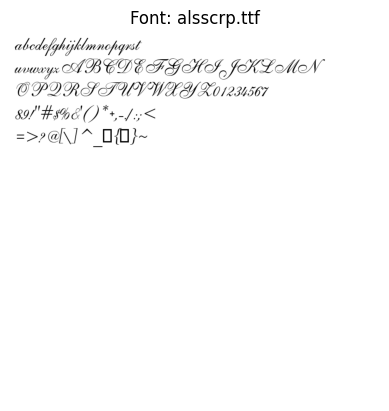

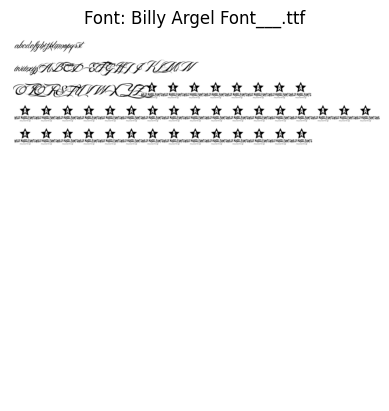

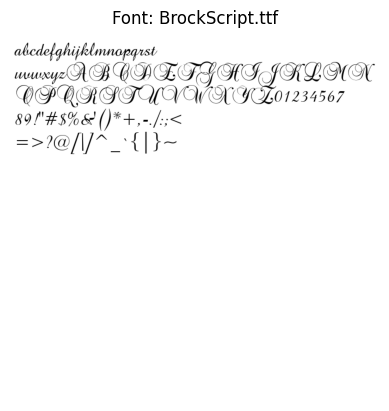

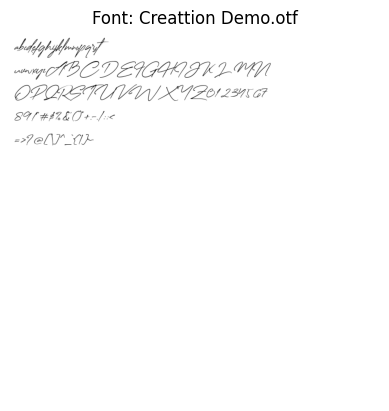

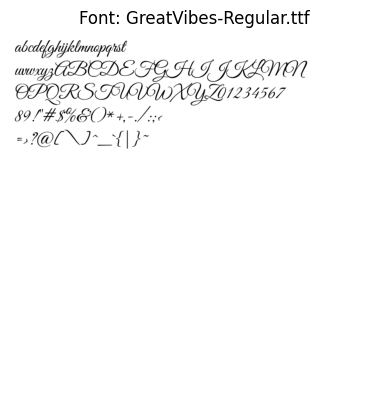

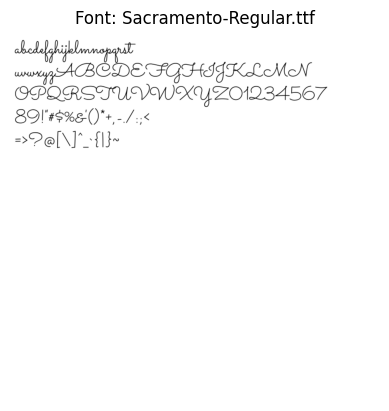

In [5]:
import os
from PIL import ImageFont, ImageDraw, Image
import matplotlib.pyplot as plt
import string

# Directory containing the font files
font_directory = 'fonts/'  # Change to your fonts folder path

# Function to print ASCII characters using a font, stacking lines
def render_ascii_stacked(font_path):
    try:
        # Load the font
        font = ImageFont.truetype(font_path, 40)
        
        # Create a blank image with enough height for stacked lines
        image_width = 800
        image_height = 800
        image = Image.new("RGB", (image_width, image_height), "white")
        draw = ImageDraw.Draw(image)
        
        # Get all ASCII characters
        ascii_chars = string.ascii_letters + string.digits + string.punctuation
        
        # Break the ASCII characters into lines that fit the image width
        max_chars_per_line = image_width // 40  # 40 is the font size
        lines = [ascii_chars[i:i + max_chars_per_line] for i in range(0, len(ascii_chars), max_chars_per_line)]
        
        # Draw each line of ASCII characters on the image
        y_offset = 10
        for line in lines:
            draw.text((10, y_offset), line, font=font, fill="black")
            y_offset += 50  # Move to the next line (50 is the line height)

        # Display the image
        plt.imshow(image)
        plt.title(f"Font: {os.path.basename(font_path)}")
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"Failed to load {font_path}: {e}")

# Iterate over all font files in the directory
for font_file in os.listdir(font_directory):
    if font_file.lower().endswith(('.ttf', '.otf')):
        font_path = os.path.join(font_directory, font_file)
        render_ascii_stacked(font_path)

In [26]:
import json
import random

# Load the dataset.json
with open('dataset.json', 'r') as f:
    dataset = json.load(f)

# Load the synthetic_notes_dataset.json
with open('synthetic_notes_dataset.json', 'r') as f:
    synthetic_notes_data = json.load(f)

with open('font_dataset_3.json', 'r') as f:
    font_dataset = json.load(f)

# Combine the two datasets
combined_dataset = dataset + synthetic_notes_data + font_dataset

# Shuffle the combined dataset to ensure randomness
random.shuffle(combined_dataset)

# Split the combined dataset into 90% train and 10% validation
split_index = int(0.9 * len(combined_dataset))
train_data = combined_dataset[:split_index]
val_data = combined_dataset[split_index:]

# Save the train.json
with open('train.json', 'w') as f:
    json.dump(train_data, f, indent=4)

# Save the val.json
with open('val.json', 'w') as f:
    json.dump(val_data, f, indent=4)

print(f"Train and validation sets created: {len(train_data)} train samples, {len(val_data)} validation samples.")

Train and validation sets created: 17978 train samples, 1998 validation samples.
